In [1]:
#Import Libraries
from pymatgen.core.composition import Composition, Element
from pymatgen.core.structure import SiteCollection
from matminer.featurizers.composition.alloy import Miedema, WenAlloys,YangSolidSolution
from matminer.featurizers.composition import ElementFraction
from matminer.featurizers.conversions import StrToComposition
from matminer.utils.data import MixingEnthalpy, DemlData
from matminer.utils import data_files #for importing "Miedema.csv" present inside package of Matminer library
from matplotlib.ticker import MultipleLocator # for minor tick lines
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
import matplotlib.pyplot as plt

ef= ElementFraction()
stc = StrToComposition()

# Data Extraction from Materials Project

In [2]:
from mp_api.client import MPRester

# First, create an instance of the MPRester class by providing your Materials Project API key.
mpr = MPRester("B3DbKy9eVvr2DjaPIqUqYBSj9WIlFUOk")


# Now, use the "{end_point}.search" method to retrieve the data that matches the query.

data = mpr.piezoelectric.search(fields=["material_id","formula_pretty", 'e_ij_max','total'])


#mpr.materials.available_fields
# mpr.{end_point}.{to view available information provided in particular endpoint}

#mpr.piezoelectric.available_fields

/home/sachin/.local/lib/python3.8/site-packages/mp_api/client/mprester.py:146: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


MPRestError: REST query returned with error status code 404 on URL https://api.materialsproject.org/piezoelectric/?_limit=1000&_fields=material_id%2Cformula_pretty%2Ce_ij_max%2Ctotal with message:
Response {"message":"no Route matched with those values"}

In [ ]:
data

In [ ]:
# convert a list of Pydantic BaseModels to Pandas Dataframe

# Import pandas package
import pandas as pd
#pd.DataFrame([dict(s) for s in data])
df_piezo_test = pd.DataFrame([s.__dict__ for s in data_test])
df_piezo_test = df_piezo_test.drop(['fields_not_requested'], axis=1)

df_piezo_test['total'] =  df_piezo_test.total.apply(lambda x: [list(round(z, 3) for z in y) for y in x])

# Add a column track_id to place value 1 to length_dataframe
track_id = list(range(1,len(df_piezo_test)+1))
df_piezo_test['track_id'] = track_id

In [ ]:
# convert a list of Pydantic BaseModels to Pandas Dataframe

# Import pandas package
import pandas as pd
#pd.DataFrame([dict(s) for s in data])
df_piezo = pd.DataFrame([s.__dict__ for s in data])
df_piezo = df_piezo.drop(['fields_not_requested'], axis=1)

df_piezo['total'] =  df_piezo.total.apply(lambda x: [list(round(z, 3) for z in y) for y in x])

# Add a column track_id to place value 1 to length_dataframe
track_id = list(range(1,len(df_piezo)+1))
df_piezo['track_id'] = track_id

In [ ]:
df_piezo

In [3]:
# Add categories of crystal structure and point group in pf_piezo

df2 = pd.DataFrame()

for number in range(len(df_piezo_test)):
    symmetry_data = df_piezo_test.symmetry[number]  #SymmetryData(crystal_system=<CrystalSystem.ortho: 'Orthorhombic'>, symbol='Pmn2_1', number=31, point_group='mm2', symprec=0.1, version='1.16.2')

    # create a dictionary to store the data
    data1 = {'crystal_system': symmetry_data.crystal_system,
            'point_group': symmetry_data.point_group}

    # create a DataFrame from the dictionary
    
    
    df1 = pd.DataFrame(data1, index=[0])
    #df2 = pd.concat([df2, df1], axis=0)

    df2 = pd.concat([df2, df1], axis=0)
    
    #df1 = pd.concat([df1, data1], axis=0)
df2 = df2.reset_index()
df_piezo = pd.concat([df_piezo, df2], axis=1)

NameError: name 'df_piezo_test' is not defined

In [4]:
df_piezo

NameError: name 'df_piezo' is not defined

In [4]:
df_piezo["crystal"] = df_piezo["crystal_system"].astype(str) +str(" ") + df_piezo["point_group"]


NameError: name 'df_piezo' is not defined

In [6]:
df_piezo

NameError: name 'df_piezo' is not defined

In [7]:
df_piezo['crystal'].value_counts()

NameError: name 'df_piezo' is not defined

In [ ]:
#df_piezo.to_csv('csv/piezo_crystal_(MaterialsProject).csv',index=False)

In [3]:
df_piezo = pd.read_csv('csv/piezo_crystal_(MaterialsProject).csv')

In [4]:
import ast

def str_to_list(s):
    return ast.literal_eval(s)

# Apply the function to the dataframe
df_piezo['total'] = df_piezo['total'].apply(str_to_list)

In [5]:
# Define function to classify tensors
def tensor_classification(df_piezo):
    def classify_tensor(tensor):
        tensor = np.array(tensor)
        if (tensor == 0).sum() == 15 and tensor[0,3]==tensor[1,4]==tensor[2,5] != 0:
            category = 'cubic'
            target = tensor[0,3]

        elif (tensor == 0).sum() == 15 and tensor[0,3] == tensor[1,4] != 0 and tensor[2,5] != 0:
            category = 'tetra-42m'
            target = [tensor[0,3], tensor[2,5]]

        elif (tensor == 0).sum() == 15 and tensor[0,3]!= 0 and tensor[1,4]!= 0 and tensor[2,5] != 0:
            category = 'ortho222'
            target = [tensor[0,3], tensor[1,4], tensor[2,5]]



        elif (tensor == 0).sum() == 13 and tensor[0,4]== tensor[1,3]!= 0 and tensor[2,0]== tensor[2,1]!= 0 and tensor[2,2]!= 0:
            category = 'hextetramm'
            target = [tensor[0,4], tensor[2,0], tensor[2,2]]        

        elif (tensor == 0).sum() == 13 and tensor[0,4]!= 0 and tensor[1,3]!= 0 and tensor[2,0]!= 0 and tensor[2,1]!= 0 and tensor[2,2]!= 0:
            category = 'orthomm2'
            target = [tensor[0,4], tensor[1,3], tensor[2,0], tensor[2,1], tensor[2,2]]

    #     elif (tensor == 0).sum() == 18:
    #         category = 'AllZero'
    #         target = 0        

        else:
            category = 'other'
            target = [ ]
        return category, target

    
    # Apply function to create new columns
    df_piezo['subcategory'], df_piezo['target'] = zip(*df_piezo['total'].apply(classify_tensor))
    
    cat_a_list = ['cubic', 'tetra-42m', 'ortho222']
    cat_b_list = ['hextetramm', 'orthomm2']

    # Use apply() method with a lambda function to categorize column 'category' values
    df_piezo['category'] = df_piezo['subcategory'].apply(lambda x: 'CAT A' if x in cat_a_list else ('CAT B' if x in cat_b_list else 'Other'))
        

    df_piezo = df_piezo.drop(['index', 'crystal_system', 'point_group','crystal'], axis=1)
    
    for col in ['e_ij_max', 'target']:
        df_piezo[col] = df_piezo.pop(col)

    return df_piezo


In [6]:
df_piezo = tensor_classification(df_piezo)

In [7]:
df_piezo_all = df_piezo

df_piezo = df_piezo.loc[df_piezo['category'].isin(['CAT A','CAT B'])]

df_piezo = df_piezo.reset_index(drop=True)

In [8]:
df_piezo = stc.featurize_dataframe(df_piezo, "formula_pretty",ignore_errors=True,return_errors=True)
df_piezo = ef.featurize_dataframe(df_piezo, "composition",ignore_errors=True,return_errors=True)

StrToComposition:   0%|          | 0/1356 [00:00<?, ?it/s]

ElementFraction:   0%|          | 0/1356 [00:00<?, ?it/s]

In [9]:
from matminer.featurizers.composition import ElementProperty
featurizer = ElementProperty.from_preset('magpie')
df_piezo = featurizer.featurize_dataframe(df_piezo, col_id='composition')
#y = bg_data_featurized['gap expt']


ElementProperty:   0%|          | 0/1356 [00:00<?, ?it/s]

In [10]:
df_piezo

,formula_pretty,material_id,total,track_id,subcategory,category,e_ij_max,target,composition,StrToComposition Exceptions,H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al,Si,P,S,Cl,Ar,K,Ca,Sc,Ti,V,Cr,Mn,Fe,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Br,Kr,Rb,Sr,Y,Zr,Nb,Mo,Tc,Ru,Rh,Pd,Ag,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,Fr,Ra,Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr,ElementFraction Exceptions,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData minimum Column,MagpieData maximum Column,MagpieData range Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData minimum Row,MagpieData maximum Row,MagpieData range Row,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mode Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData range NsValence,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mode NsValence,MagpieData minimum NpValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mode NpValence,MagpieData minimum NdValence,MagpieData maximum NdValence,MagpieData range NdValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mode NdValence,MagpieData minimum NfValence,MagpieData maximum NfValence,MagpieData range NfValence,MagpieData mean NfValence,MagpieData avg_dev NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData minimum NsUnfilled,MagpieData maximum NsUnfilled,MagpieData range NsUnfilled,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mode NsUnfilled,MagpieData minimum NpUnfilled,MagpieData maximum NpUnfilled,MagpieData range NpUnfilled,MagpieData mean NpUnfilled,MagpieData avg_dev NpUnfilled,MagpieData mode NpUnfilled,MagpieData minimum NdUnfilled,MagpieData maximum NdUnfilled,MagpieData range NdUnfilled,MagpieData mean NdUnfilled,MagpieData avg_dev NdUnfilled,MagpieData mode NdUnfilled,MagpieData minimum NfUnfilled,MagpieData maximum NfUnfilled,MagpieData range NfUnfilled,MagpieData mean NfUnfilled,MagpieData avg_dev NfUnfilled,MagpieData mode NfUnfilled,MagpieData minimum NUnfilled,MagpieData maximum NUnfilled,MagpieData range NUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData mode NUnfilled,MagpieData minimum GSvolume_pa,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData minimum GSmagmom,MagpieData maximum GSmagmom,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSm

In [12]:
%run functions.ipynb
df_piezo = elements_occurance(df_piezo)

    Occurrence
Xe           1
Gd           2
Eu           2
Ce           3
Ru           6
Tb           8
Pd           9
Pr          11
Sc          12
Rh          13
Mo          13
Nd          13
Sm          14
Ti          22
Cr          22
La          23
Zr          26
In          27
Ni          29
Y           29
Co          29
Br          30
Cs          30
I           36
Rb          39
Fe          40
Nb          42
Cd          46
Sr          46
C           50
V           51
Be          52
Ca          54
Mg          56
Mn          57
B           57
Ag          62
As          62
Ga          62
Ba          69
Sn          73
Cl          76
Te          79
K           89
Cu          91
Al          91
Sb          96
Zn          98
F           99
Ge         100
Na         116
Se         133
Si         156
P          163
N          174
Li         211
S          212
O          647
lenght:   21
lenght:   20
lenght:   17


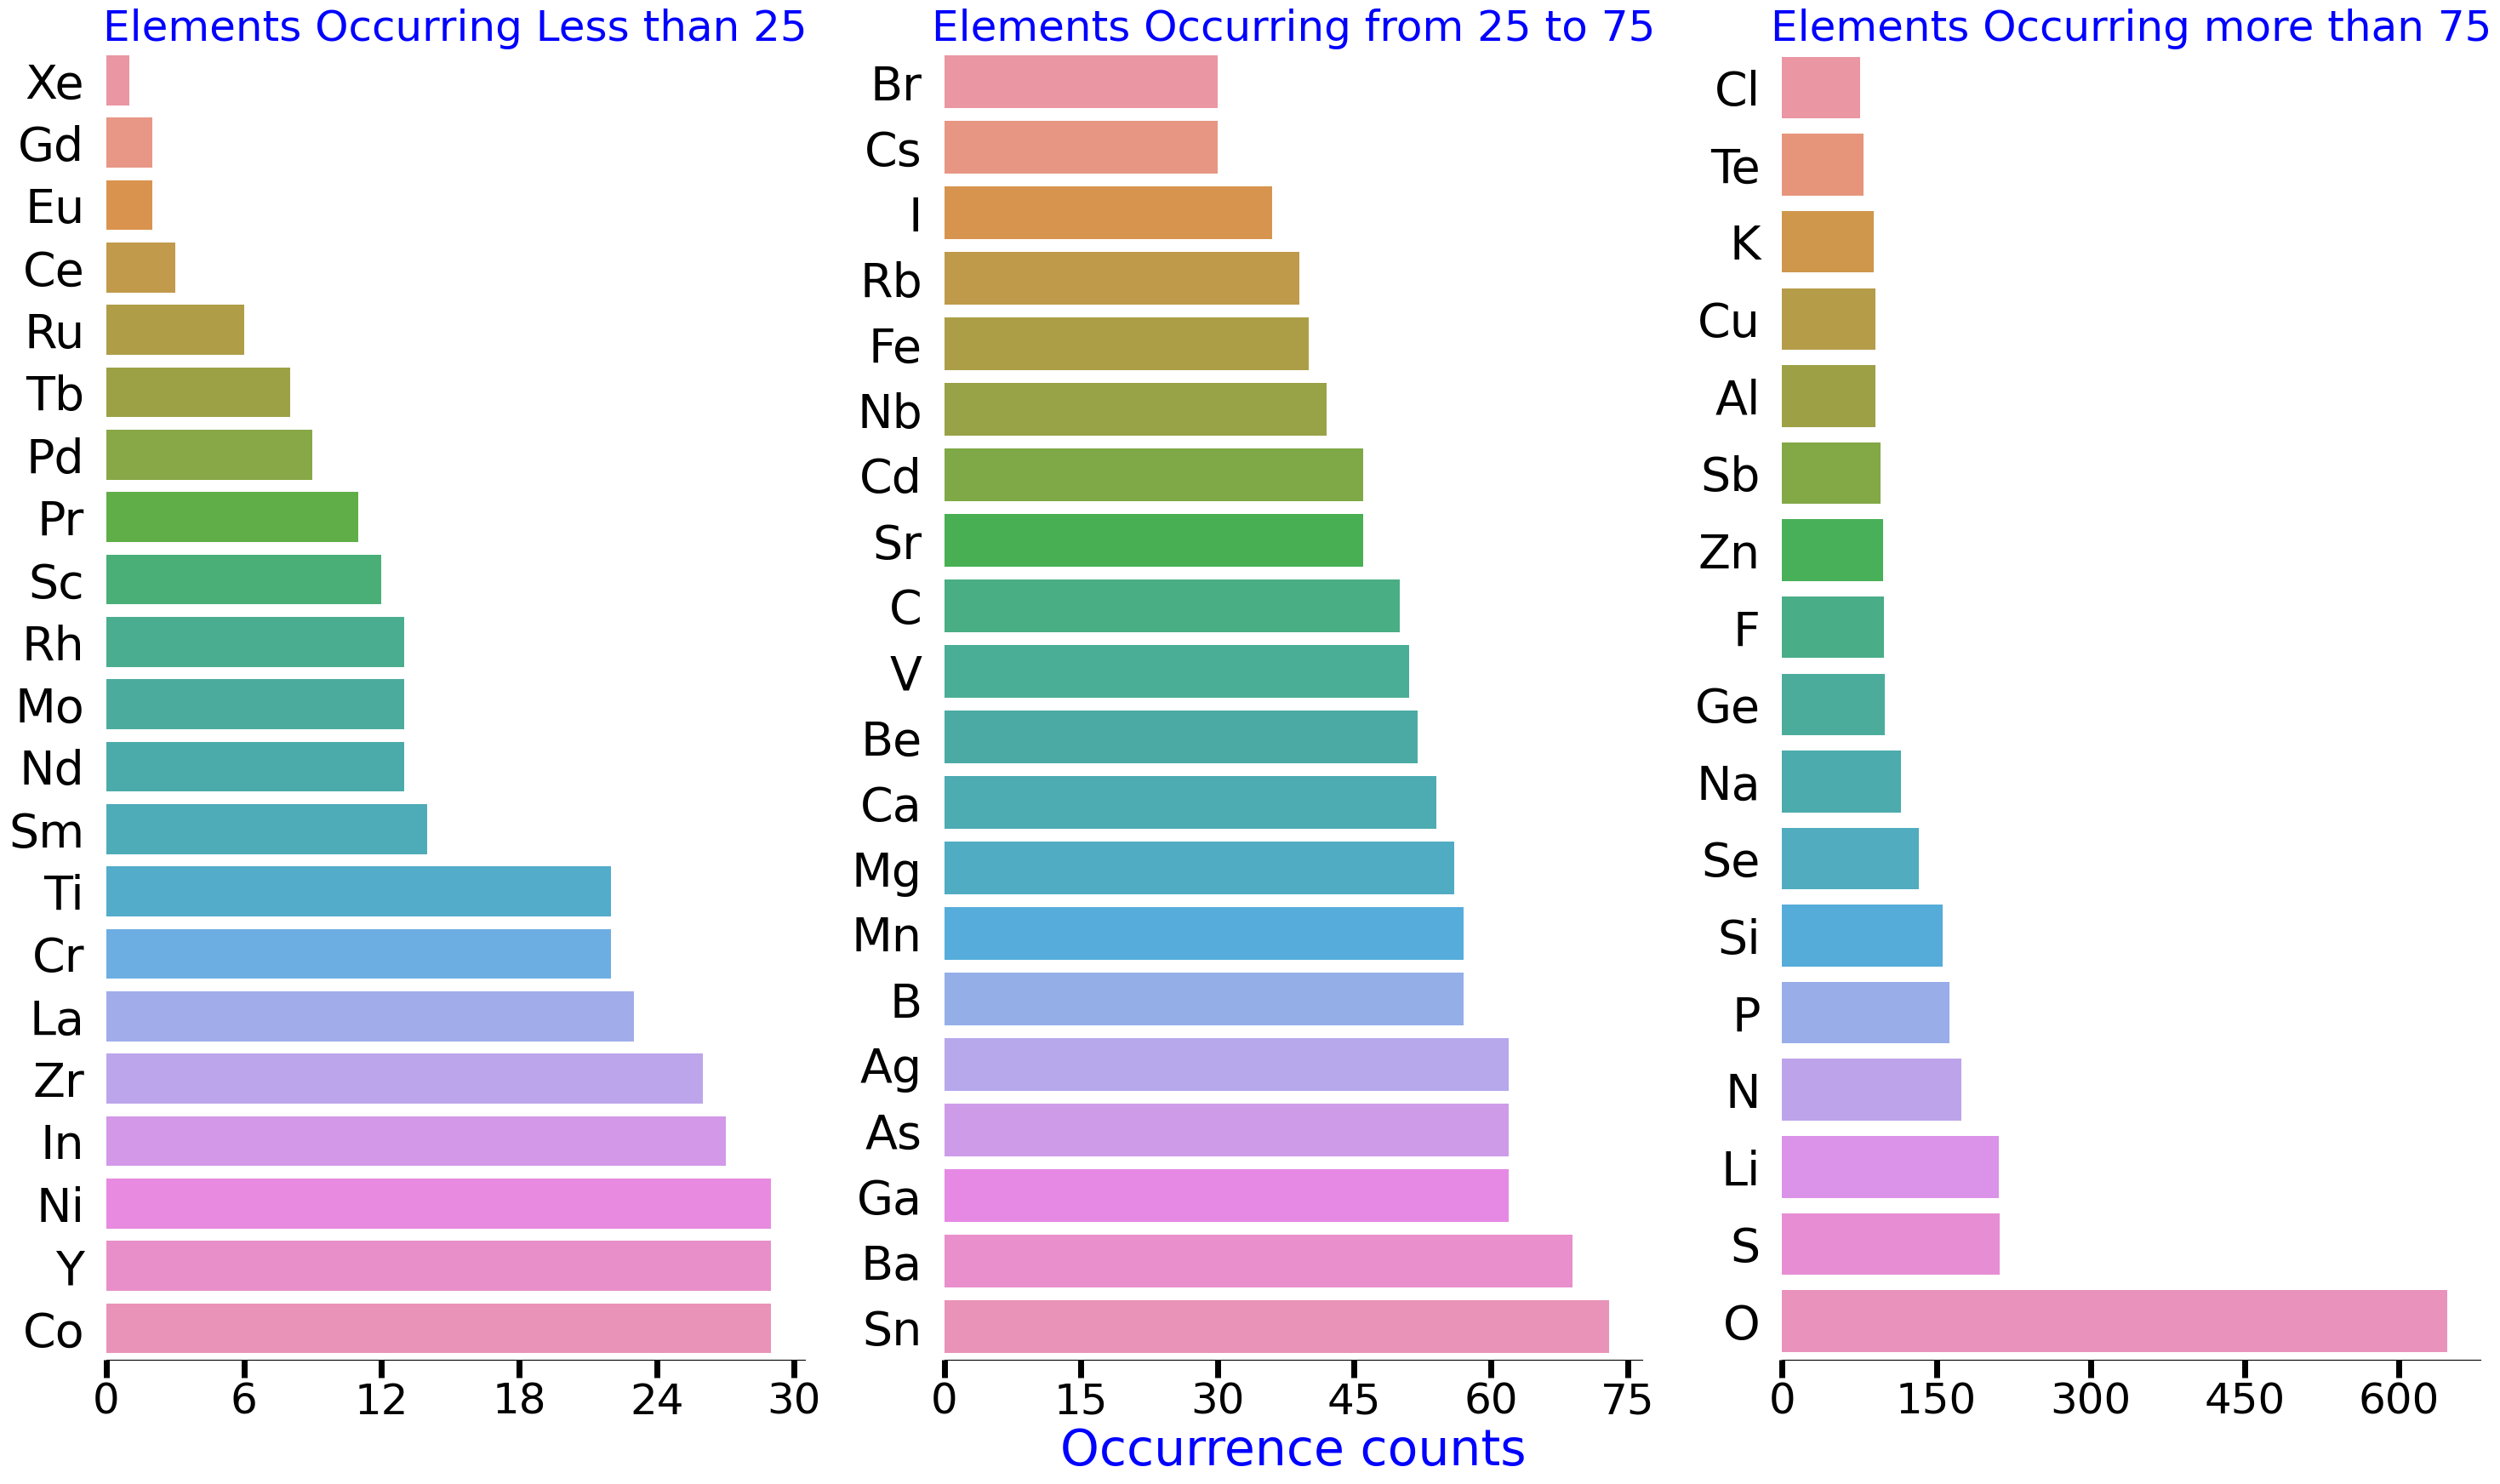

In [13]:
%run functions.ipynb
element_occurrence(df_piezo,limit_value=11, fig_title='Occurrence', fig_name='plots\\element_occurrence')

In [14]:
%run functions.ipynb
df, df_input_target = properties_calculation(df_piezo)

/tmp/ipykernel_7433/181570130.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0, 820,400)


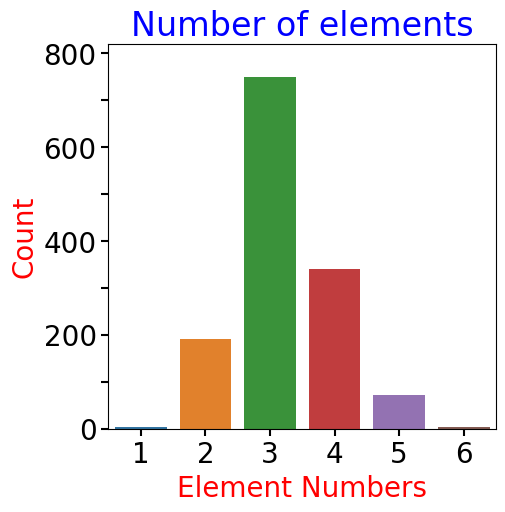

In [16]:
%run functions.ipynb
element_number(df, fig_title='Elements Number', fig_name='plots\\element_number.png')

In [17]:
df_input_target

#print(df_input_target.head())

,No of Components,$\delta$,Δ$\chi$,ΔTm,Tm(K),VEC,AN,K,B,ΔB,G,ΔG,ΔSmix,$\lambda$,subcategory,category,total,e_ij_max,target
0,3,0.590535,1.1870,675.083204,439.351250,4.000000,11.000000,56.388290,49.142500,0.961850,28.987500,0.687330,8.1005,23.2283,orthomm2,CAT B,"[[0.0, 0.0, 0.0, 0.0, 0.383, 0.0], [0.0, 0.0, ...",1.190230,"[0.383, 0.415, 0.5, 0.493, -0.961]"
1,4,0.587625,0.7370,677.987410,435.295556,5.666667,19.222222,20.573276,64.595556,0.525916,46.166667,0.570860,8.3366,24.1428,hextetramm,CAT B,"[[0.0, 0.0, 0.0, 0.0, -0.047, 0.0], [0.0, 0.0,...",0.084143,"[-0.047, -0.047, 0.051]"
2,3,0.636473,0.7361,1316.972832,782.757143,5.285714,19.714286,23.876129,57.257143,0.328981,53.357143,0.441039,6.6205,16.3430,orthomm2,CAT B,"[[0.0, 0.0, 0.0, 0.0, -0.09, 0.0], [0.0, 0.0, ...",0.517998,"[-0.09, 0.022, 0.381, 0.013, -0.35]"
3,5,0.581325,1.0277,562.105536,442.351739,4.521739,10.347826,74.579472,52.044348,0.561106,34.400000,0.448683,10.9024,32.2616,cubic,CAT A,"[[0.0, 0.0, 0.0, 0.201, 0.0, 0.0], [0.0, 0.0, ...",0.200670,0.201
4,3,0.440894,0.6515,546.022223,773.150000,4.857143,39.428571,8.260000,22.028571,0.758010,32.085714,0.448433,7.9457,40.8755,ortho222,CAT A,"[[0.0, 0.0, 0.0, -0.656, 0.0, 0.0], [0.0, 0.0,...",0.656000,"[-0.656, -0.562, -0.562]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,4,0.575800,0.9822,403.386616,287.048333,5.083333,9.750000,14.871505,44.910000,0.666821,37.158333,0.396665,9.3012,28.0541,ortho222,CAT A,"[[0.0, 0.0, 0.0, 0.248, 0.0, 0.0], [0.0, 0.0, ...",0.248230,"[0.248, 0.184, 0.184]"
1352,4,0.344270,0.5720,803.444295,923.731250,6.500000,21.750000,124.352500,60.887500,1.142579,39.037500,0.353994,10.0849,85.0892,orthomm2,CAT B,"[[0.0, 0.0, 0.0, 0.0, -11.854, 0.0], [0.0, 0.0...",11.854210,"[-11.854, -0.641, -0.262, -0.42, -0.343]"
1353,3,0.530646,0.7385,194.902036,203.661429,4.857143,25.142857,13.300903,52.480000,0.050409,38.300000,0.348557,7.9457,28.2177,orthomm2,CAT B,"[[0.0, 0.0, 0.0, 0.0, 0.285, 0.0], [0.0, 0.0, ...",1.073001,"[0.285, 0.634, 0.631, 0.49, -0.716]"
1354,5,0.754440,1.3058,833.637612,426.492000,4.800000,14.200000,47.916284,56.386000,1.098664,28.840000,0.656173,12.5108,21.9804,hextetramm,CAT B,"[[0.0, 0.0, 0.0, 0.0, 0.042, 0.0], [0.0, 0.0, ...",0.768228,"[0.042, -0.113, 0.752]"


In [18]:
#df_fs_magpie = df.iloc[:,list(range(92,220))]
df_fs_magpie = df.iloc[:,list(range(91,219))]


In [19]:

list(df_fs_magpie.columns.values.tolist())

['MagpieData minimum Number',
 'MagpieData maximum Number',
 'MagpieData range Number',
 'MagpieData mean Number',
 'MagpieData avg_dev Number',
 'MagpieData mode Number',
 'MagpieData minimum MendeleevNumber',
 'MagpieData maximum MendeleevNumber',
 'MagpieData range MendeleevNumber',
 'MagpieData mean MendeleevNumber',
 'MagpieData avg_dev MendeleevNumber',
 'MagpieData mode MendeleevNumber',
 'MagpieData minimum AtomicWeight',
 'MagpieData maximum AtomicWeight',
 'MagpieData range AtomicWeight',
 'MagpieData mean AtomicWeight',
 'MagpieData avg_dev AtomicWeight',
 'MagpieData mode AtomicWeight',
 'MagpieData minimum MeltingT',
 'MagpieData maximum MeltingT',
 'MagpieData range MeltingT',
 'MagpieData mean MeltingT',
 'MagpieData avg_dev MeltingT',
 'MagpieData mode MeltingT',
 'MagpieData minimum Column',
 'MagpieData maximum Column',
 'MagpieData range Column',
 'MagpieData mean Column',
 'MagpieData avg_dev Column',
 'MagpieData mode Column',
 'MagpieData minimum Row',
 'MagpieDat

In [20]:
df['No of Components'].value_counts()

3    749
4    339
2    190
5     72
1      3
6      3
Name: No of Components, dtype: int64

In [21]:
df_fs_magpie

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData minimum Column,MagpieData maximum Column,MagpieData range Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData minimum Row,MagpieData maximum Row,MagpieData range Row,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mode Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData range NsValence,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mode NsValence,MagpieData minimum NpValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mode NpValence,MagpieData minimum NdValence,MagpieData maximum NdValence,MagpieData range NdValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mode NdValence,MagpieData minimum NfValence,MagpieData maximum NfValence,MagpieData range NfValence,MagpieData mean NfValence,MagpieData avg_dev NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData minimum NsUnfilled,MagpieData maximum NsUnfilled,MagpieData range NsUnfilled,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mode NsUnfilled,MagpieData minimum NpUnfilled,MagpieData maximum NpUnfilled,MagpieData range NpUnfilled,MagpieData mean NpUnfilled,MagpieData avg_dev NpUnfilled,MagpieData mode NpUnfilled,MagpieData maximum NdUnfilled,MagpieData range NdUnfilled,MagpieData mean NdUnfilled,MagpieData avg_dev NdUnfilled,MagpieData mode NdUnfilled,MagpieData maximum NfUnfilled,MagpieData range NfUnfilled,MagpieData mean NfUnfilled,MagpieData avg_dev NfUnfilled,MagpieData minimum NUnfilled,MagpieData maximum NUnfilled,MagpieData range NUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData mode NUnfilled,MagpieData minimum GSvolume_pa,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData maximum GSmagmom,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,8.0,23.0,15.0,11.000000,3.000000,8.0,2.0,87.0,85.0,50.000000,37.000000,87.0,15.999400,50.941500,34.942100,22.988551,6.989151,15.9994,54.80,2183.00,2128.20,439.351250,435.912187,54.80,1.0,16.0,15.0,9.000000,7.000000,16.0,2.0,4.0,2.0,2.625000,0.625000,2.0,66.0,166.0,100.0,114.375000,48.375000,66.0,0.93,3.44,2.51,2.272500,1.167500,3.44,1.0,2

In [22]:
df.head()

,formula_pretty,material_id,total,track_id,subcategory,category,e_ij_max,target,composition,StrToComposition Exceptions,H,Li,Be,B,C,N,O,F,Na,Mg,Al,Si,P,S,Cl,K,Ca,Sc,Ti,V,Cr,Mn,Fe,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Br,Rb,Sr,Y,Zr,Nb,Mo,Ru,Rh,Pd,Ag,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Ac,Th,U,ElementFraction Exceptions,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData minimum Column,MagpieData maximum Column,MagpieData range Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData minimum Row,MagpieData maximum Row,MagpieData range Row,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mode Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData range NsValence,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mode NsValence,MagpieData minimum NpValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mode NpValence,MagpieData minimum NdValence,MagpieData maximum NdValence,MagpieData range NdValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mode NdValence,MagpieData minimum NfValence,MagpieData maximum NfValence,MagpieData range NfValence,MagpieData mean NfValence,MagpieData avg_dev NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData minimum NsUnfilled,MagpieData maximum NsUnfilled,MagpieData range NsUnfilled,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mode NsUnfilled,MagpieData minimum NpUnfilled,MagpieData maximum NpUnfilled,MagpieData range NpUnfilled,MagpieData mean NpUnfilled,MagpieData avg_dev NpUnfilled,MagpieData mode NpUnfilled,MagpieData maximum NdUnfilled,MagpieData range NdUnfilled,MagpieData mean NdUnfilled,MagpieData avg_dev NdUnfilled,MagpieData mode NdUnfilled,MagpieData maximum NfUnfilled,MagpieData range NfUnfilled,MagpieData mean NfUnfilled,MagpieData avg_dev NfUnfilled,MagpieData minimum NUnfilled,MagpieData maximum NUnfilled,MagpieData range NUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData mode NUnfilled,MagpieData minimum GSvolume_pa,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData maximum GSmagmom,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,Mag

In [23]:
df_input_target = df_input_target.drop(['No of Components'], axis=1)

In [24]:
df_features = pd.concat([df_fs_magpie,df_input_target], axis=1)
df_inputs = df_features.drop(['e_ij_max','total'], axis=1)
#df_targets = df_features.loc[df_features['e_ij_max','total']]
df_targets = df_features[['e_ij_max', 'total']]

In [25]:
df_features = df_features[df_features['e_ij_max'] <= 30]

In [26]:
df_features

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData minimum Column,MagpieData maximum Column,MagpieData range Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData minimum Row,MagpieData maximum Row,MagpieData range Row,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mode Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData range NsValence,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mode NsValence,MagpieData minimum NpValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mode NpValence,MagpieData minimum NdValence,MagpieData maximum NdValence,MagpieData range NdValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mode NdValence,MagpieData minimum NfValence,MagpieData maximum NfValence,MagpieData range NfValence,MagpieData mean NfValence,MagpieData avg_dev NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData minimum NsUnfilled,MagpieData maximum NsUnfilled,MagpieData range NsUnfilled,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mode NsUnfilled,MagpieData minimum NpUnfilled,MagpieData maximum NpUnfilled,MagpieData range NpUnfilled,MagpieData mean NpUnfilled,MagpieData avg_dev NpUnfilled,MagpieData mode NpUnfilled,MagpieData maximum NdUnfilled,MagpieData range NdUnfilled,MagpieData mean NdUnfilled,MagpieData avg_dev NdUnfilled,MagpieData mode NdUnfilled,MagpieData maximum NfUnfilled,MagpieData range NfUnfilled,MagpieData mean NfUnfilled,MagpieData avg_dev NfUnfilled,MagpieData minimum NUnfilled,MagpieData maximum NUnfilled,MagpieData range NUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData mode NUnfilled,MagpieData minimum GSvolume_pa,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData maximum GSmagmom,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,$\delta$,Δ$\chi$,ΔTm,Tm(K),VEC,AN,K,B,ΔB,G,ΔG,ΔSmix,$\lambda$,subcategory,category,total,e_ij_max,target
0,8.0,23.0,15.0,11.000000,3.000000,8.0,2.0,87.0,85.0,50.000000,37.000000,87.0,15.999400,50.941500,34.942100,22.988551,6.989151,15.9994,54.80,2183.00,2128.20,439.351250,435.912187,54.80,1.0,16.0,15.0,9.000000,7.000000,16.0,2.0,4.0,2.0,2.6

In [27]:
df_targets['total'][1]

[[0.0, 0.0, 0.0, 0.0, -0.047, 0.0],
 [0.0, 0.0, 0.0, -0.047, 0.0, 0.0],
 [-0.047, -0.047, 0.051, 0.0, 0.0, 0.0]]

In [28]:
df_features.to_csv('csv/piezo(Featurized)_new.csv',index=False)